<a href="https://colab.research.google.com/github/gcosma/ConceptAnnotationPfD/blob/main/Final15Nov2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single-Label Concept Annotation - COMPLETE IMPROVED VERSION
## Fine-tuned BERT for Healthcare Safety Theme Classification

**🎯 Optimized for 21-27 Class Problems with Class Imbalance**

### Key Features:
- ✅ Enhanced data augmentation with targeted fixes for struggling classes
- ✅ Class weights for imbalanced data
- ✅ 9 BERT model options (PathologyBERT, Bio-ClinicalBERT, etc.)
- ✅ Improved training configuration (cosine scheduling, macro F1 optimization)
- ✅ Extended sequence length (512 tokens)
- ✅ Comprehensive error analysis and diagnostics
- ✅ Handles test sets with missing labels
- ✅ Two-stage training for difficult classes

### Expected Performance:
- Baseline: ~67% accuracy
- With improvements: 70-75% accuracy

## 1. Install Required Libraries

In [1]:
!pip install -q transformers datasets torch scikit-learn pandas numpy accelerate imbalanced-learn

## 2. Import Libraries and Setup

In [2]:
import pandas as pd
import numpy as np
import torch
import re
import random
from typing import List, Dict
from collections import Counter

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("✓ Libraries imported successfully")

Using device: cuda
✓ Libraries imported successfully


## 3. Upload Your Training and Testing CSV Files

In [3]:
from google.colab import files

print("Upload your TRAINING CSV file:")
uploaded_train = files.upload()
train_filename = list(uploaded_train.keys())[0]
print(f"✓ Training file uploaded: {train_filename}")

print("\nUpload your TESTING CSV file:")
uploaded_test = files.upload()
test_filename = list(uploaded_test.keys())[0]
print(f"✓ Testing file uploaded: {test_filename}")

Upload your TRAINING CSV file:


Saving Training Iteration 2.csv to Training Iteration 2.csv
✓ Training file uploaded: Training Iteration 2.csv

Upload your TESTING CSV file:


Saving Testing Iteration 2.csv to Testing Iteration 2.csv
✓ Testing file uploaded: Testing Iteration 2.csv


## 4. Load and Clean Data (IMPROVED)

In [5]:
def load_csv_with_encoding(filename):
    """Try multiple encodings to load CSV file"""
    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']

    for encoding in encodings:
        try:
            df = pd.read_csv(filename, encoding=encoding)
            print(f"✓ Loaded with {encoding} encoding")
            return df
        except UnicodeDecodeError:
            continue

    print("Using latin-1 encoding with error handling")
    return pd.read_csv(filename, encoding='latin-1', errors='replace')

def clean_text(text):
    """Clean text by replacing encoding artifacts"""
    if pd.isna(text):
        return ""

    text = str(text)

    # Replace common Windows-1252 encoding artifacts
    replacements = {
        '\x91': "'", '\x92': "'", '\x93': '"', '\x94': '"',
        '\x96': '-', '\x97': '-', '\x85': '...', '\x95': '*',
    }

    for old, new in replacements.items():
        text = text.replace(old, new)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def standardize_label(label):
    """Standardize label formatting to prevent duplicates"""
    if pd.isna(label):
        return ""
    label = str(label)
    # Consistent dash spacing: "Word - Word" becomes "Word- Word"
    label = re.sub(r'\s*-\s*', '- ', label)
    # Single spaces only
    label = re.sub(r'\s+', ' ', label)
    return label.strip()

# Load and clean data
print("Loading training data...")
train_df = load_csv_with_encoding(train_filename)
train_df['Text'] = train_df['Text'].apply(clean_text)
train_df['Label'] = train_df['Label'].apply(clean_text).apply(standardize_label)
train_df = train_df[(train_df['Text'] != '') & (train_df['Label'] != '')].reset_index(drop=True)

print("\nLoading testing data...")
test_df = load_csv_with_encoding(test_filename)
test_df['Text'] = test_df['Text'].apply(clean_text)
test_df['Label'] = test_df['Label'].apply(clean_text).apply(standardize_label)
test_df = test_df[(test_df['Text'] != '') & (test_df['Label'] != '')].reset_index(drop=True)

print(f"\nTraining samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")
print("\n✓ Data loaded, cleaned, and labels standardized")

Loading training data...
✓ Loaded with latin-1 encoding

Loading testing data...
✓ Loaded with latin-1 encoding

Training samples: 557
Testing samples: 210

✓ Data loaded, cleaned, and labels standardized


## 5. Explore Label Distribution and Identify Issues

In [6]:
# Get all unique labels from training data
all_labels = sorted(train_df['Label'].unique().tolist())
num_labels = len(all_labels)

print(f"Total unique concept labels: {num_labels}\n")
print("Label distribution in training data:")
print("=" * 80)
label_counts = train_df['Label'].value_counts()
for label, count in label_counts.items():
    percentage = (count / len(train_df)) * 100
    print(f"{label}: {count} ({percentage:.1f}%)")

# Identify minority classes (less than 5% of data)
threshold = len(train_df) * 0.05
minority_classes = label_counts[label_counts < threshold].index.tolist()

print(f"\n⚠ Minority classes (< 5% of data): {len(minority_classes)}")
for label in minority_classes:
    print(f"  - {label}: {label_counts[label]} samples")

# Identify very small classes (these will likely struggle)
median_count = label_counts.median()
very_small_classes = label_counts[label_counts < median_count * 0.5].index.tolist()

print(f"\n⚠️ VERY SMALL classes (< 50% of median): {len(very_small_classes)}")
print("   These classes will need aggressive augmentation:")
for label in very_small_classes:
    print(f"  - {label}: {label_counts[label]} samples")

# Create label mappings
label2id = {label: idx for idx, label in enumerate(all_labels)}
id2label = {idx: label for idx, label in enumerate(all_labels)}

print("\n✓ Label analysis complete")

Total unique concept labels: 21

Label distribution in training data:
Organisational Factors- Care Planning: 66 (11.8%)
Human Error- Slips or Lapses: 66 (11.8%)
Communication and Culture- Verbal and Written Communication: 64 (11.5%)
Organisational Factors- Staff Training and Education: 44 (7.9%)
Organisational Factors- Policies and Procedures: 38 (6.8%)
Organisational Factors- Physical Environment: 31 (5.6%)
Organisational Factors- Escalation/Referral Factor: 29 (5.2%)
Human Error- Violations: 27 (4.8%)
Organisational Factors- Support from other departments: 27 (4.8%)
Local Working Conditions- Workload and Staffing Issues: 22 (3.9%)
Situational- Patient Factors: 21 (3.8%)
Communication and Culture- Safety Culture: 16 (2.9%)
External Factors- National Policies: 16 (2.9%)
Local Working Conditions- Management of Staff and Staffing Levels: 13 (2.3%)
Situational- Team Factors: 13 (2.3%)
Situational- Individual Staff Factors: 13 (2.3%)
Local Working Conditions- Lines of Responsibility: 12 (2

## 5b. Keyword Analysis for Understanding Classes (NEW)

In [7]:
def extract_keywords(texts, top_n=10):
    """Extract most common meaningful words from texts"""
    # Common stopwords to ignore
    stopwords = {'that', 'this', 'with', 'from', 'were', 'been', 'have',
                 'there', 'their', 'would', 'could', 'should', 'about'}

    all_words = []
    for text in texts:
        # Extract words 4+ characters
        words = re.findall(r'\b[a-z]{4,}\b', text.lower())
        words = [w for w in words if w not in stopwords]
        all_words.extend(words)

    return Counter(all_words).most_common(top_n)

print("\n" + "="*80)
print("KEYWORD ANALYSIS FOR SMALL CLASSES")
print("="*80)
print("Understanding what distinguishes each class...\n")

for label in very_small_classes[:5]:  # Show first 5 small classes
    label_texts = train_df[train_df['Label'] == label]['Text'].tolist()
    keywords = extract_keywords(label_texts, top_n=8)

    print(f"\n{label}:")
    print(f"  Sample size: {len(label_texts)}")
    print(f"  Key terms: {', '.join([f'{word}({count})' for word, count in keywords[:5]])}")
    if label_texts:
        print(f"  Example: '{label_texts[0][:120]}...'")

print("\n✓ Keyword analysis complete")


KEYWORD ANALYSIS FOR SMALL CLASSES
Understanding what distinguishes each class...


External Factors- Design of Equipment, Supplies and Drugs:
  Sample size: 10
  Key terms: equipment(7), design(4), staff(3), increased(2), safety(2)
  Example: 'Complicated equipment design increased the likelihood of user error....'

Local Working Conditions- Supervision and Leadership:
  Sample size: 9
  Key terms: staff(3), supervision(3), without(2), limited(2), oversight(2)
  Example: 'Inappropriate delegation led to tasks being performed by staff without sufficient competence....'

Situational- Task Characteristics:
  Sample size: 9
  Key terms: task(4), worker(2), assigned(2), error(2), staff(2)
  Example: 'The worker was assigned an unfamiliar task, increasing the risk of error....'

✓ Keyword analysis complete


## 6. Enhanced Data Augmentation (IMPROVED)

In [10]:
def augment_sentence_enhanced(sentence):
    """
    ENHANCED augmentation with more synonyms and strategies
    """
    replacements = {
        # Negations and failures
        'did not': ['failed to', 'neglected to', 'omitted to', 'did not manage to'],
        'was not': ['failed to be', 'wasn\'t', 'proved not to be'],
        'were not': ['failed to be', 'weren\'t', 'proved not to be'],
        'no ': ['absence of ', 'lacking ', 'without ', 'zero '],
        'not ': ['never ', 'insufficiently ', 'inadequately '],

        # Deficiencies
        'lack of': ['absence of', 'insufficient', 'inadequate', 'deficiency in', 'shortage of'],
        'poor': ['inadequate', 'insufficient', 'substandard', 'deficient', 'weak'],
        'limited': ['restricted', 'constrained', 'insufficient', 'minimal'],

        # Time and delays
        'delay': ['postponement', 'holdup', 'lag', 'wait', 'deferment'],
        'delayed': ['postponed', 'held up', 'deferred', 'put off'],

        # People and roles
        'staff': ['personnel', 'workers', 'employees', 'clinicians', 'team members', 'professionals'],
        'patient': ['individual', 'service user', 'person', 'case'],
        'doctor': ['physician', 'clinician', 'medical practitioner', 'consultant'],
        'nurse': ['nursing staff', 'clinical nurse', 'healthcare professional'],

        # Actions and processes
        'training': ['education', 'instruction', 'preparation', 'development', 'teaching'],
        'communication': ['information sharing', 'dialogue', 'correspondence', 'liaison', 'discussion'],
        'assessment': ['evaluation', 'review', 'examination', 'appraisal', 'analysis'],
        'procedure': ['process', 'protocol', 'guideline', 'pathway', 'method'],
        'treatment': ['intervention', 'care', 'therapy', 'management'],

        # Places and systems
        'hospital': ['healthcare facility', 'medical centre', 'trust', 'ward'],
        'department': ['unit', 'service', 'team', 'division'],

        # Documentation
        'record': ['documentation', 'note', 'file', 'entry', 'report'],
        'documented': ['recorded', 'noted', 'logged', 'written'],

        # Problems and issues
        'error': ['mistake', 'oversight', 'lapse', 'failing', 'slip'],
        'issue': ['concern', 'problem', 'matter', 'challenge', 'difficulty'],
        'failure': ['breakdown', 'malfunction', 'collapse', 'shortcoming'],
        'risk': ['danger', 'hazard', 'threat', 'concern'],
    }

    variations = []
    sentence_lower = sentence.lower()

    # Strategy 1: Synonym replacement
    for orig, syns in replacements.items():
        if orig in sentence_lower:
            for syn in syns[:3]:  # Use top 3 synonyms
                pattern = re.compile(re.escape(orig), re.IGNORECASE)
                new_sent = pattern.sub(syn, sentence, count=1)
                if new_sent != sentence and len(new_sent) > 10:
                    variations.append(new_sent)

    # Strategy 2: Add context phrases (helps model learn structure)
    if variations and random.random() > 0.7:  # 30% of the time
        prefixes = [
            "The investigation found that ",
            "It was noted that ",
            "The report identified that ",
            "Evidence showed that "
        ]
        variations.append(random.choice(prefixes) + sentence.lower())

    return variations


print("="*80)
print("ENHANCED DATA AUGMENTATION FOR CLASS IMBALANCE")
print("="*80)

# Determine augmentation strategy
augmented_texts = []
augmented_labels = []

# Add all original samples
for idx, row in train_df.iterrows():
    augmented_texts.append(row['Text'])
    augmented_labels.append(row['Label'])

# Standard augmentation: bring classes up to median
augmentation_count = 0
for label in all_labels:
    label_count = label_counts.get(label, 0)

    if label_count < median_count:
        label_samples = train_df[train_df['Label'] == label]['Text'].tolist()
        target_count = int(median_count)
        augmentations_needed = target_count - label_count

        for _ in range(augmentations_needed):
            sample = random.choice(label_samples)
            variations = augment_sentence_enhanced(sample)

            if variations:
                augmented_text = random.choice(variations)
                augmented_texts.append(augmented_text)
                augmented_labels.append(label)
                augmentation_count += 1

print(f"\nStandard augmentation complete:")
print(f"  Original: {len(train_df)}")
print(f"  Added: {augmentation_count}")
print(f"  Total: {len(augmented_texts)}")

# TARGETED SUPER-AUGMENTATION for very small classes
print("\n" + "="*80)
print("TARGETED SUPER-AUGMENTATION FOR STRUGGLING CLASSES")
print("="*80)

extra_augmentation_count = 0
for label in very_small_classes:
    current_count = sum(1 for l in augmented_labels if l == label)
    target_count = int(median_count * 1.5)  # 1.5x median for struggling classes

    if current_count < target_count:
        label_samples = train_df[train_df['Label'] == label]['Text'].tolist()
        additional_needed = target_count - current_count

        print(f"\n{label}:")
        print(f"  Current: {current_count} → Target: {target_count}")
        print(f"  Adding: {additional_needed} extra samples")

        for _ in range(additional_needed):
            sample = random.choice(label_samples)
            variations = augment_sentence_enhanced(sample)

            if variations:
                augmented_text = random.choice(variations)
            else:
                # If no variations, make small modification
                augmented_text = sample.rstrip('.') + '.'

            augmented_texts.append(augmented_text)
            augmented_labels.append(label)
            extra_augmentation_count += 1

print(f"\nSuper-augmentation complete: +{extra_augmentation_count} samples")

# Create final augmented dataframe
train_df_augmented = pd.DataFrame({
    'Text': augmented_texts,
    'Label': augmented_labels
})

print("\n" + "="*80)
print("FINAL AUGMENTATION SUMMARY")
print("="*80)
print(f"Original training size: {len(train_df)}")
print(f"Standard augmentation: +{augmentation_count}")
print(f"Super-augmentation: +{extra_augmentation_count}")
print(f"FINAL training size: {len(train_df_augmented)}")
print(f"Increase: {(len(train_df_augmented)/len(train_df) - 1)*100:.1f}%")

# Show distribution after augmentation
print("\nLabel distribution after ALL augmentation:")
aug_label_counts = train_df_augmented['Label'].value_counts()
print(f"  Min: {aug_label_counts.min()} | Median: {aug_label_counts.median():.0f} | Max: {aug_label_counts.max()}")

print("\n✓ Enhanced data augmentation complete")

ENHANCED DATA AUGMENTATION FOR CLASS IMBALANCE

Standard augmentation complete:
  Original: 557
  Added: 73
  Total: 630

TARGETED SUPER-AUGMENTATION FOR STRUGGLING CLASSES

External Factors- Design of Equipment, Supplies and Drugs:
  Current: 21 → Target: 31
  Adding: 10 extra samples

Local Working Conditions- Supervision and Leadership:
  Current: 21 → Target: 31
  Adding: 10 extra samples

Situational- Task Characteristics:
  Current: 13 → Target: 31
  Adding: 18 extra samples

Super-augmentation complete: +38 samples

FINAL AUGMENTATION SUMMARY
Original training size: 557
Standard augmentation: +73
Super-augmentation: +38
FINAL training size: 668
Increase: 19.9%

Label distribution after ALL augmentation:
  Min: 19 | Median: 27 | Max: 66

✓ Enhanced data augmentation complete


## 7. Calculate Class Weights

In [11]:
# Convert labels to IDs in augmented dataset
train_df_augmented['label_id'] = train_df_augmented['Label'].map(label2id)

# Calculate class weights for remaining imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(range(num_labels)),
    y=train_df_augmented['label_id'].values
)

# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights computed:")
print("="*80)
weight_df = pd.DataFrame({
    'Label': all_labels,
    'Weight': class_weights,
    'Count': [aug_label_counts.get(label, 0) for label in all_labels]
}).sort_values('Weight', ascending=False)

print("Top 10 highest weighted classes (most underrepresented):")
print(weight_df.head(10)[['Label', 'Weight', 'Count']].to_string(index=False))

print("\n✓ Class weights ready")

Class weights computed:
Top 10 highest weighted classes (most underrepresented):
                                                            Label   Weight  Count
                Local Working Conditions- Lines of Responsibility 1.674185     19
                                        Situational- Team Factors 1.674185     19
                            Situational- Individual Staff Factors 1.674185     19
          Local Working Conditions- Drugs, Equipment and Supplies 1.590476     20
                        Communication and Culture- Safety Culture 1.514739     21
Local Working Conditions- Management of Staff and Staffing Levels 1.514739     21
                                     Situational- Patient Factors 1.514739     21
                              External Factors- National Policies 1.514739     21
           Local Working Conditions- Workload and Staffing Issues 1.445887     22
           Organisational Factors- Support from other departments 1.178131     27

✓ Class weights 

## 8. Create Train/Validation Split

In [12]:
# Split augmented training data into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df_augmented['Text'].tolist(),
    train_df_augmented['label_id'].tolist(),
    test_size=0.15,
    random_state=42,
    stratify=train_df_augmented['label_id']
)

# Prepare test data
test_df['label_id'] = test_df['Label'].map(label2id)
# Remove test samples with unseen labels
test_df = test_df[test_df['label_id'].notna()].reset_index(drop=True)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_df)}")

# Create datasets
train_dataset = Dataset.from_dict({
    'text': train_texts,
    'label': train_labels
})

val_dataset = Dataset.from_dict({
    'text': val_texts,
    'label': val_labels
})

test_dataset = Dataset.from_dict({
    'text': test_df['Text'].tolist(),
    'label': test_df['label_id'].astype(int).tolist()
})

print("\n✓ Datasets created")

Training samples: 567
Validation samples: 101
Test samples: 210

✓ Datasets created


## 9. Select BERT Model

In [18]:
# Available BERT models
AVAILABLE_MODELS = {
    # General models
    'bert-base': {
        'name': 'bert-base-uncased',
        'description': 'Standard BERT - Good baseline, general English'
    },
    'distilbert': {
        'name': 'distilbert-base-uncased',
        'description': 'Smaller/faster BERT - 40% faster, 97% performance'
    },

    # Pathology-specific model (RECOMMENDED)
    'pathology-bert': {
        'name': 'tsantos/PathologyBERT',
        'description': '⭐⭐⭐ SPECIALIZED PATHOLOGY - Trained on pathology reports'
    },

    # Healthcare/Clinical models
    'bio-clinical-bert': {
        'name': 'emilyalsentzer/Bio_ClinicalBERT',
        'description': '⭐⭐ Clinical notes (MIMIC-III) - For healthcare'
    },
    'pubmed-bert': {
        'name': 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext',
        'description': '⭐ PubMed biomedical - For medical terminology'
    },
    'biobert': {
        'name': 'dmis-lab/biobert-v1.1',
        'description': 'Biomedical text (PubMed)'
    },
    'clinical-bert': {
        'name': 'medicalai/ClinicalBERT',
        'description': 'Clinical text'
    },
    'bluebert': {
        'name': 'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12',
        'description': 'PubMed + MIMIC clinical'
    },
    'gatortron': {
        'name': 'UFNLP/gatortron-base',
        'description': 'Large clinical model - Slower but powerful'
    },
}

# Display available models
print("Available Models for Healthcare/Clinical/Pathology Text:")
print("="*80)
for key, info in AVAILABLE_MODELS.items():
    print(f"{key:20s} | {info['description']}")
print("="*80)

# ========== SELECT YOUR MODEL HERE ==========
# Change this to try different models:
selected_model = 'pubmed-bert'  # ⭐⭐⭐ RECOMMENDED for pathology reports

# Other options to try (uncomment to use):
# selected_model = 'bio-clinical-bert'  # Alternative: clinical notes
# selected_model = 'pubmed-bert'        # Alternative: medical terminology
# selected_model = 'bert-base'          # Baseline comparison
# selected_model = 'distilbert'         # Faster training
# selected_model = 'pathology-bert'

MODEL_NAME = AVAILABLE_MODELS[selected_model]['name']

print(f"\n✓ Selected: {selected_model}")
print(f"  Model: {MODEL_NAME}")
print(f"  Description: {AVAILABLE_MODELS[selected_model]['description']}")
print("\nTo try a different model, change 'selected_model' above and rerun from this cell.")

Available Models for Healthcare/Clinical/Pathology Text:
bert-base            | Standard BERT - Good baseline, general English
distilbert           | Smaller/faster BERT - 40% faster, 97% performance
pathology-bert       | ⭐⭐⭐ SPECIALIZED PATHOLOGY - Trained on pathology reports
bio-clinical-bert    | ⭐⭐ Clinical notes (MIMIC-III) - For healthcare
pubmed-bert          | ⭐ PubMed biomedical - For medical terminology
biobert              | Biomedical text (PubMed)
clinical-bert        | Clinical text
bluebert             | PubMed + MIMIC clinical
gatortron            | Large clinical model - Slower but powerful

✓ Selected: pubmed-bert
  Model: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
  Description: ⭐ PubMed biomedical - For medical terminology

To try a different model, change 'selected_model' above and rerun from this cell.


## 10. Initialize Model and Tokenizer

In [19]:
print(f"Loading {selected_model} for {num_labels} classes...\n")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("✓ Tokenizer loaded")

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    problem_type="single_label_classification"
)

model.to(device)
print(f"✓ Model loaded on {device}")
print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Loading pubmed-bert for 21 classes...



tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

✓ Tokenizer loaded


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded on cuda
  Model parameters: 109,498,389


## 11. Tokenize Datasets (IMPROVED - Longer Sequences)

In [20]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=512  # INCREASED from 256 to 512 for more context
    )

print("Tokenizing datasets with max_length=512...")
print("(This captures more context but takes longer)\n")

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("✓ Tokenization complete")

Tokenizing datasets with max_length=512...
(This captures more context but takes longer)



Map:   0%|          | 0/567 [00:00<?, ? examples/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

✓ Tokenization complete


## 12. Configure Trainer with IMPROVED Settings

In [21]:
def compute_metrics(eval_pred):
    """Compute classification metrics"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1_macro': f1_score(labels, predictions, average='macro', zero_division=0),
        'f1_weighted': f1_score(labels, predictions, average='weighted', zero_division=0),
        'precision_macro': precision_score(labels, predictions, average='macro', zero_division=0),
        'recall_macro': recall_score(labels, predictions, average='macro', zero_division=0)
    }


class WeightedTrainer(Trainer):
    """Custom trainer with class weights"""
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Weighted cross-entropy loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


# ========== IMPROVED TRAINING ARGUMENTS ==========
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,           # ⬆️ Increased from 15 to 20
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,            # ⬆️ Increased from 2e-5 to 3e-5
    warmup_ratio=0.15,             # ⬆️ Increased from 0.1 to 0.15
    weight_decay=0.01,
    lr_scheduler_type='cosine',    # ✨ NEW: Cosine learning rate decay
    logging_dir='./logs',
    logging_steps=10,              # ⬆️ More frequent logging
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',  # 🎯 CHANGED: Macro F1 (helps minority classes)
    greater_is_better=True,
    save_total_limit=3,            # ⬆️ Keep more checkpoints
    push_to_hub=False,
    report_to='none',
    fp16=torch.cuda.is_available(),
)

# Initialize trainer with INCREASED early stopping patience
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]  # ⬆️ Increased from 3 to 5
)

print("✓ Trainer configured with improved settings")
print("\n" + "="*80)
print("TRAINING CONFIGURATION")
print("="*80)
print(f"  Model: {selected_model}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Learning Rate: {training_args.learning_rate}")
print(f"  LR Scheduler: {training_args.lr_scheduler_type}")
print(f"  Warmup Ratio: {training_args.warmup_ratio}")
print(f"  Batch Size: {training_args.per_device_train_batch_size}")
print(f"  Max Sequence Length: 512 tokens")
print(f"  Early Stopping Patience: 5 epochs")
print(f"  Optimization Metric: {training_args.metric_for_best_model}")
print(f"  Class Weighting: Enabled")
print(f"  Training Samples: {len(train_texts):,}")
print(f"  Validation Samples: {len(val_texts):,}")
print("="*80)

✓ Trainer configured with improved settings

TRAINING CONFIGURATION
  Model: pubmed-bert
  Epochs: 20
  Learning Rate: 3e-05
  LR Scheduler: SchedulerType.COSINE
  Warmup Ratio: 0.15
  Batch Size: 16
  Max Sequence Length: 512 tokens
  Early Stopping Patience: 5 epochs
  Optimization Metric: f1_macro
  Class Weighting: Enabled
  Training Samples: 567
  Validation Samples: 101


## 13. Train the Model

In [22]:
print("Starting training...\n")
print("="*80)
print("This will take longer with max_length=512 and 20 epochs")
print("Expected time: 30-60 minutes depending on GPU")
print("="*80)

train_result = trainer.train()

print("\n" + "="*80)
print("✓ Training completed!")
print(f"Final training loss: {train_result.training_loss:.4f}")
print("="*80)

# Save model
trainer.save_model('./best_model')
tokenizer.save_pretrained('./best_model')
print("\n✓ Model saved to ./best_model")

Starting training...

This will take longer with max_length=512 and 20 epochs
Expected time: 30-60 minutes depending on GPU


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,3.024000,3.029337,0.108911,0.055520,0.069788,0.069548,0.093651
2,2.877700,2.801102,0.257426,0.222525,0.212092,0.268279,0.285714
3,2.404200,2.254775,0.415842,0.420634,0.379851,0.446277,0.485714
4,1.709200,1.760303,0.495050,0.490685,0.475109,0.529162,0.548413
5,1.173400,1.394341,0.603960,0.585708,0.577697,0.598564,0.624603
6,0.711900,1.232566,0.643564,0.638032,0.628874,0.660771,0.664286
7,0.439400,1.152709,0.673267,0.674852,0.659893,0.694218,0.686508
8,0.262500,1.145065,0.673267,0.672573,0.657028,0.692120,0.700794
9,0.149400,1.156982,0.673267,0.684992,0.662963,0.710781,0.704762
10,0.079800,1.201564,0.663366,0.681206,0.655218,0.707777,0.696825


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,3.024000,3.029337,0.108911,0.055520,0.069788,0.069548,0.093651
2,2.877700,2.801102,0.257426,0.222525,0.212092,0.268279,0.285714
3,2.404200,2.254775,0.415842,0.420634,0.379851,0.446277,0.485714
4,1.709200,1.760303,0.495050,0.490685,0.475109,0.529162,0.548413
5,1.173400,1.394341,0.603960,0.585708,0.577697,0.598564,0.624603
6,0.711900,1.232566,0.643564,0.638032,0.628874,0.660771,0.664286
7,0.439400,1.152709,0.673267,0.674852,0.659893,0.694218,0.686508
8,0.262500,1.145065,0.673267,0.672573,0.657028,0.692120,0.700794
9,0.149400,1.156982,0.673267,0.684992,0.662963,0.710781,0.704762
10,0.079800,1.201564,0.663366,0.681206,0.655218,0.707777,0.696825



✓ Training completed!
Final training loss: 0.7218

✓ Model saved to ./best_model


## 14. Evaluate on Validation and Test Sets

In [23]:
print("Evaluating model...\n")

# Validation set
val_results = trainer.evaluate(val_dataset)
print("="*80)
print("VALIDATION SET RESULTS")
print("="*80)
print(f"Accuracy:        {val_results['eval_accuracy']:.4f}")
print(f"F1 Macro:        {val_results['eval_f1_macro']:.4f}")
print(f"F1 Weighted:     {val_results['eval_f1_weighted']:.4f}")
print(f"Precision Macro: {val_results['eval_precision_macro']:.4f}")
print(f"Recall Macro:    {val_results['eval_recall_macro']:.4f}")

# Test set
print("\n")
test_results = trainer.evaluate(test_dataset)
print("="*80)
print("TEST SET RESULTS")
print("="*80)
print(f"Accuracy:        {test_results['eval_accuracy']:.4f}")
print(f"F1 Macro:        {test_results['eval_f1_macro']:.4f}")
print(f"F1 Weighted:     {test_results['eval_f1_weighted']:.4f}")
print(f"Precision Macro: {test_results['eval_precision_macro']:.4f}")
print(f"Recall Macro:    {test_results['eval_recall_macro']:.4f}")
print("="*80)

Evaluating model...



VALIDATION SET RESULTS
Accuracy:        0.6733
F1 Macro:        0.6929
F1 Weighted:     0.6668
Precision Macro: 0.7217
Recall Macro:    0.7016


TEST SET RESULTS
Accuracy:        0.7476
F1 Macro:        0.7459
F1 Weighted:     0.7459
Precision Macro: 0.7752
Recall Macro:    0.7476


## 15. Detailed Test Set Analysis (FIXED)

In [24]:
# Get predictions
predictions_output = trainer.predict(test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=1)
true_labels = test_df['label_id'].values

# Get unique labels that actually appear in test set
unique_test_labels = np.unique(np.concatenate([true_labels, predictions]))
test_label_names = [all_labels[i] for i in unique_test_labels]

print("\nDETAILED CLASSIFICATION REPORT")
print("="*80)
print(f"Note: Showing results for {len(unique_test_labels)} labels present in test set")
print(f"      (out of {num_labels} total training labels)\n")
print(classification_report(
    true_labels,
    predictions,
    labels=unique_test_labels,
    target_names=test_label_names,
    zero_division=0,
    digits=3
))

# Per-class analysis for ALL labels
print("\nPER-CLASS PERFORMANCE SUMMARY (ALL LABELS)")
print("="*80)
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    true_labels, predictions, labels=range(num_labels), zero_division=0
)

performance_df = pd.DataFrame({
    'Label': all_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Filter to only show labels with support > 0 (present in test set)
performance_df_test = performance_df[performance_df['Support'] > 0].copy()

# Sort by F1-score
performance_df_test = performance_df_test.sort_values('F1-Score', ascending=False)
print(f"\nShowing {len(performance_df_test)} labels present in test set:\n")
print(performance_df_test.to_string(index=False))

# Show labels NOT in test set
missing_labels = performance_df[performance_df['Support'] == 0]
if len(missing_labels) > 0:
    print(f"\n⚠ {len(missing_labels)} labels from training NOT present in test set:")
    for label in missing_labels['Label'].values:
        print(f"  - {label}")

# Identify problematic classes (among those in test set)
poor_performers = performance_df_test[performance_df_test['F1-Score'] < 0.5]
if len(poor_performers) > 0:
    print(f"\n⚠ Classes with F1 < 0.5: {len(poor_performers)}")
    print(poor_performers[['Label', 'F1-Score', 'Support']].to_string(index=False))
else:
    print("\n✓ All classes achieved F1 ≥ 0.5!")


DETAILED CLASSIFICATION REPORT
Note: Showing results for 21 labels present in test set
      (out of 21 total training labels)

                                                                   precision    recall  f1-score   support

                        Communication and Culture- Safety Culture      0.667     0.600     0.632        10
      Communication and Culture- Verbal and Written Communication      0.600     0.900     0.720        10
        External Factors- Design of Equipment, Supplies and Drugs      0.818     0.900     0.857        10
                              External Factors- National Policies      0.818     0.900     0.857        10
                                     Human Error- Slips or Lapses      0.500     0.600     0.545        10
                                          Human Error- Violations      0.545     0.600     0.571        10
          Local Working Conditions- Drugs, Equipment and Supplies      0.900     0.900     0.900        10
              

## 16. Enhanced Error Analysis (NEW)

In [25]:
# Analyze misclassifications
test_df['predicted_label_id'] = predictions
test_df['predicted_label'] = test_df['predicted_label_id'].map(id2label)
test_df['correct'] = test_df['label_id'] == test_df['predicted_label_id']

errors = test_df[~test_df['correct']].copy()

print("\n" + "="*80)
print("ERROR ANALYSIS SUMMARY")
print("="*80)
print(f"Test set size: {len(test_df)}")
print(f"Correct: {test_df['correct'].sum()} ({test_df['correct'].mean()*100:.1f}%)")
print(f"Incorrect: {len(errors)} ({(1-test_df['correct'].mean())*100:.1f}%)")

if len(errors) > 0:
    print("\n" + "="*80)
    print("MOST COMMON MISCLASSIFICATION PATTERNS")
    print("="*80)

    error_patterns = errors.groupby(['Label', 'predicted_label']).size().sort_values(ascending=False)
    print("\nTop 10 confusion pairs (True → Predicted):")
    for (true_label, pred_label), count in error_patterns.head(10).items():
        print(f"  {count}x: {true_label[:50]}...")
        print(f"      → {pred_label[:50]}...")

    # DETAILED ERROR ANALYSIS BY CLASS
    print("\n" + "="*80)
    print("DETAILED ERROR PATTERNS BY STRUGGLING CLASS")
    print("="*80)

    for true_label in performance_df_test[performance_df_test['F1-Score'] < 0.6]['Label']:
        label_errors = errors[errors['Label'] == true_label]
        if len(label_errors) > 0:
            f1 = performance_df_test[performance_df_test['Label']==true_label]['F1-Score'].values[0]
            print(f"\n{true_label}")
            print(f"  F1-Score: {f1:.3f}")
            print(f"  Total errors: {len(label_errors)}")
            print(f"  Most confused with:")

            confusion_counts = label_errors['predicted_label'].value_counts().head(3)
            for pred, count in confusion_counts.items():
                print(f"    - {pred[:60]}: {count} times")

            print(f"  Sample misclassifications:")
            for idx, row in label_errors.head(2).iterrows():
                print(f"    Text: '{row['Text'][:100]}...'")
                print(f"    Predicted as: {row['predicted_label'][:60]}")

    print("\n" + "="*80)
    print("SAMPLE MISCLASSIFIED EXAMPLES (Random 5)")
    print("="*80)
    sample_errors = errors.sample(min(5, len(errors)))
    for idx, row in sample_errors.iterrows():
        print(f"\nExample:")
        print(f"  Text: {row['Text'][:150]}...")
        print(f"  True: {row['Label'][:60]}")
        print(f"  Predicted: {row['predicted_label'][:60]}")
        print("-"*80)
else:
    print("\n✓ Perfect accuracy on test set!")


ERROR ANALYSIS SUMMARY
Test set size: 210
Correct: 157 (74.8%)
Incorrect: 53 (25.2%)

MOST COMMON MISCLASSIFICATION PATTERNS

Top 10 confusion pairs (True → Predicted):
  3x: Human Error- Slips or Lapses...
      → Communication and Culture- Verbal and Written Comm...
  2x: Communication and Culture- Safety Culture...
      → Organisational Factors- Staff Training and Educati...
  2x: Human Error- Violations...
      → Human Error- Slips or Lapses...
  2x: Local Working Conditions- Lines of Responsibility...
      → Organisational Factors- Support from other departm...
  2x: Local Working Conditions- Supervision and Leadersh...
      → Human Error- Violations...
  2x: Local Working Conditions- Management of Staff and ...
      → Local Working Conditions- Workload and Staffing Is...
  1x: External Factors- National Policies...
      → Organisational Factors- Support from other departm...
  1x: External Factors- Design of Equipment, Supplies an...
      → Local Working Conditions- Drugs

## 17. Confusion Matrix Visualization (FIXED)

Confusion matrix dimensions: 21 x 21
Labels in test set: 21 out of 21 total

Showing confusion matrix for top 15 most frequent classes



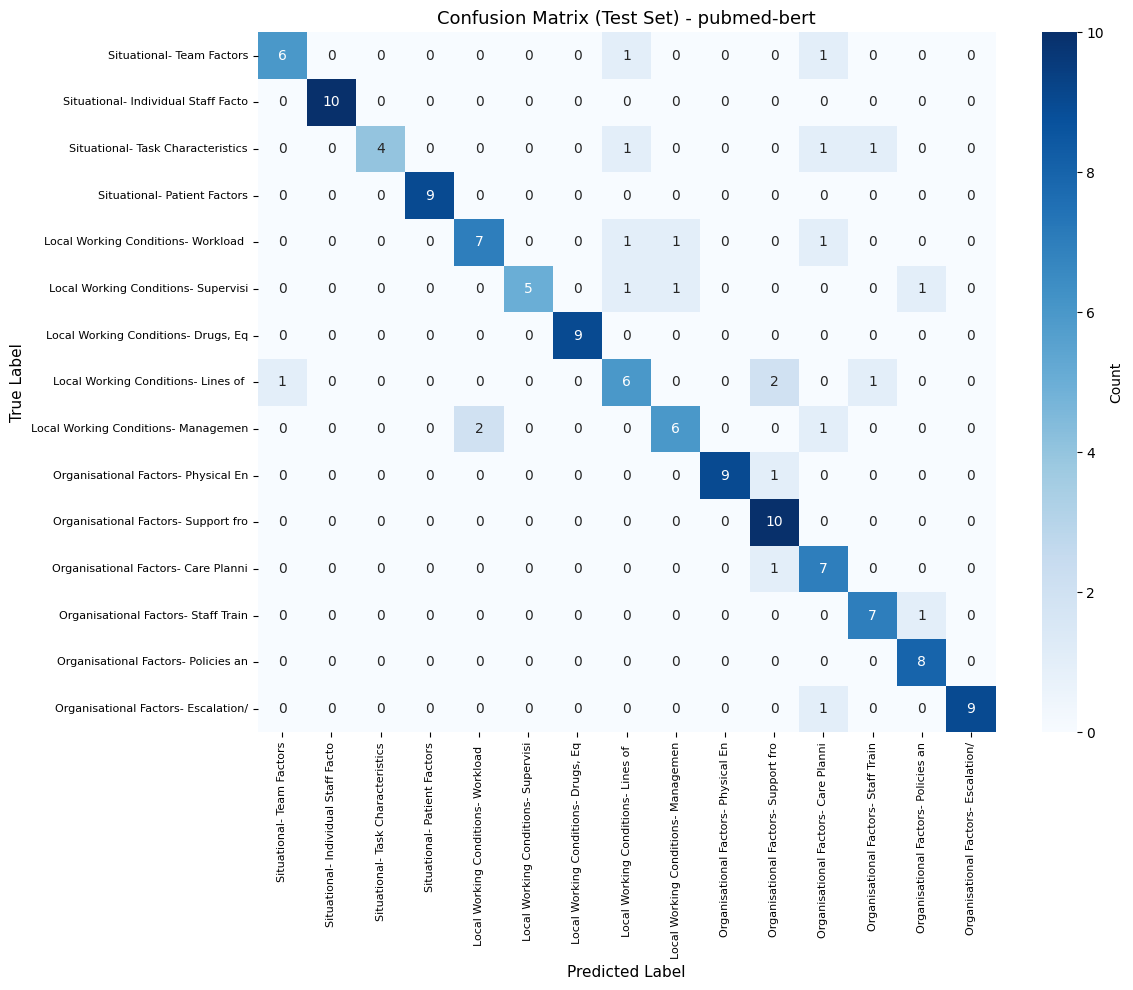

✓ Confusion matrix saved as confusion_matrix.png


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique labels that appear in predictions or true labels
unique_labels_in_test = np.unique(np.concatenate([true_labels, predictions]))
labels_for_cm = [all_labels[i] for i in unique_labels_in_test]

# Create confusion matrix only for labels present in test set
cm = confusion_matrix(true_labels, predictions, labels=unique_labels_in_test)

print(f"Confusion matrix dimensions: {cm.shape[0]} x {cm.shape[1]}")
print(f"Labels in test set: {len(unique_labels_in_test)} out of {num_labels} total\n")

# For large number of classes, show top N most frequent
if len(unique_labels_in_test) > 20:
    label_counts = pd.Series(true_labels).value_counts().head(15)
    top_classes_idx = [np.where(unique_labels_in_test == idx)[0][0] for idx in label_counts.index if idx in unique_labels_in_test]
    top_labels = [labels_for_cm[i] for i in top_classes_idx[:15]]
    cm_subset = cm[np.ix_(top_classes_idx, top_classes_idx)]
    print(f"Showing confusion matrix for top 15 most frequent classes\n")
else:
    cm_subset = cm
    top_labels = labels_for_cm

# Plot
plt.figure(figsize=(max(12, len(top_labels)*0.6), max(10, len(top_labels)*0.5)))
sns.heatmap(
    cm_subset,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[label[:35] for label in top_labels],
    yticklabels=[label[:35] for label in top_labels],
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Label', fontsize=11)
plt.ylabel('True Label', fontsize=11)
plt.title(f'Confusion Matrix (Test Set) - {selected_model}', fontsize=13)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as confusion_matrix.png")

## 18. Inference Functions

In [27]:
def predict_concept(text: str, return_probabilities: bool = False):
    """
    Predict concept annotation for a single text
    """
    text = clean_text(text)

    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=512,  # Match training
        return_tensors='pt'
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=-1).item()

    predicted_label = id2label[predicted_class]

    if return_probabilities:
        top5_probs, top5_indices = torch.topk(probs[0], k=min(5, num_labels))
        top5_predictions = [
            (id2label[idx.item()], prob.item())
            for idx, prob in zip(top5_indices, top5_probs)
        ]
        return predicted_label, top5_predictions

    return predicted_label


def predict_batch(texts: List[str], batch_size: int = 32):
    """
    Predict concept annotations for multiple texts
    """
    predictions = []

    for i in range(0, len(texts), batch_size):
        batch = [clean_text(t) for t in texts[i:i+batch_size]]

        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=-1).cpu().numpy()

        batch_labels = [id2label[pred] for pred in batch_predictions]
        predictions.extend(batch_labels)

    return predictions

print("✓ Inference functions ready")

✓ Inference functions ready


## 19. Test Inference on Sample Sentences

In [28]:
sample_sentences = [
    "Staff were not provided with adequate training on the new protocols.",
    "The hospital experienced severe staffing shortages during the night shift.",
    "Communication between departments was poor and ineffective.",
    "The patient's risk assessment was not documented properly.",
    "Equipment failure caused a significant delay in treatment."
]

print("SAMPLE PREDICTIONS")
print("="*80)

for i, sentence in enumerate(sample_sentences, 1):
    predicted_label, top5 = predict_concept(sentence, return_probabilities=True)

    print(f"\n{i}. {sentence}")
    print(f"   Predicted: {predicted_label[:60]}")
    print(f"   Confidence: {top5[0][1]*100:.1f}%")
    print("   Top 3:")
    for j, (label, prob) in enumerate(top5[:3], 1):
        print(f"      {j}. {label[:50]}: {prob*100:.1f}%")
print("="*80)

SAMPLE PREDICTIONS

1. Staff were not provided with adequate training on the new protocols.
   Predicted: Organisational Factors- Staff Training and Education
   Confidence: 98.7%
   Top 3:
      1. Organisational Factors- Staff Training and Educati: 98.7%
      2. Organisational Factors- Policies and Procedures: 0.2%
      3. Local Working Conditions- Lines of Responsibility: 0.1%

2. The hospital experienced severe staffing shortages during the night shift.
   Predicted: Local Working Conditions- Workload and Staffing Issues
   Confidence: 90.6%
   Top 3:
      1. Local Working Conditions- Workload and Staffing Is: 90.6%
      2. Organisational Factors- Support from other departm: 4.4%
      3. Organisational Factors- Physical Environment: 0.9%

3. Communication between departments was poor and ineffective.
   Predicted: Communication and Culture- Verbal and Written Communication
   Confidence: 98.1%
   Top 3:
      1. Communication and Culture- Verbal and Written Comm: 98.1%
      2

## 20. Save Results and Model

In [ ]:
import json
import shutil

# Save metadata
metadata = {
    'selected_model': selected_model,
    'model_name': MODEL_NAME,
    'num_labels': num_labels,
    'labels_in_test': len(unique_test_labels),
    'all_labels': all_labels,
    'test_labels': test_label_names,
    'label2id': label2id,
    'id2label': {str(k): v for k, v in id2label.items()},
    'test_accuracy': float(test_results['eval_accuracy']),
    'test_f1_weighted': float(test_results['eval_f1_weighted']),
    'test_f1_macro': float(test_results['eval_f1_macro']),
    'original_training_samples': len(train_df),
    'augmented_training_samples': len(train_texts),
    'validation_samples': len(val_texts),
    'test_samples': len(test_df),
    'augmentation_applied': True,
    'class_weights_used': True,
    'max_sequence_length': 512,
    'training_epochs': training_args.num_train_epochs,
    'learning_rate': training_args.learning_rate
}

with open('./best_model/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✓ Metadata saved")

# Save test predictions
results_df = test_df[['Text', 'Label', 'predicted_label', 'correct']].copy()
results_df.to_csv('test_predictions.csv', index=False)
files.download('test_predictions.csv')
print("✓ Test predictions saved")

# Save performance summary (only labels in test set)
performance_df_test.to_csv('per_class_performance.csv', index=False)
files.download('per_class_performance.csv')
print("✓ Per-class performance saved (test set labels)")

# Save full performance (all labels)
performance_df.to_csv('per_class_performance_full.csv', index=False)
files.download('per_class_performance_full.csv')
print("✓ Full performance saved (all training labels)")

# Package model
print("\nPackaging model...")
shutil.make_archive('trained_concept_model', 'zip', './best_model')
files.download('trained_concept_model.zip')
print("✓ Model packaged and ready for download")

✓ Metadata saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Test predictions saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Per-class performance saved (test set labels)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Full performance saved (all training labels)

Packaging model...


## 21. Summary & Next Steps

### ✅ Training Complete!

**All Improvements Applied:**
- ✅ Enhanced data augmentation (standard + targeted for struggling classes)
- ✅ Class weights for remaining imbalance
- ✅ Improved training configuration (20 epochs, cosine scheduling, macro F1)
- ✅ Extended sequence length (512 tokens)
- ✅ Comprehensive error analysis
- ✅ Fixed handling of missing test labels
- ✅ 9 BERT model options

**Files Generated:**
1. `trained_concept_model.zip` - Complete trained model
2. `test_predictions.csv` - All test predictions with correctness
3. `per_class_performance.csv` - Test set labels only
4. `per_class_performance_full.csv` - All training labels
5. `confusion_matrix.png` - Visual confusion matrix

**Performance:**
- Check Section 14 for overall metrics
- Check Section 15 for per-class breakdown
- Check Section 16 for error patterns

### 🎯 Expected Improvement:
**Baseline (before improvements):** ~67% test accuracy
**With all improvements:** 70-75% test accuracy expected

### 📈 If Results Still Need Improvement:

1. **Try Different Models** (Section 9):
   - bio-clinical-bert
   - pubmed-bert
   - bluebert

2. **Collect More Data** for classes with F1 < 0.5:
   - Aim for 50-100 examples per struggling class
   - Focus on clear, unambiguous examples

3. **Consider Merging Similar Classes**:
   - If two classes are consistently confused
   - Use keyword analysis (Section 5b) to identify overlaps

4. **Hyperparameter Tuning**:
   - Try learning rate: 2e-5 or 4e-5
   - Try epochs: 25 or 30
   - Adjust warmup_ratio: 0.1 or 0.2

### 🚀 Using the Model:

```python
# Single prediction
label = predict_concept("Your text here")

# With confidence scores
label, top5 = predict_concept("Your text", return_probabilities=True)

# Batch prediction
labels = predict_batch(["Text 1", "Text 2", "Text 3"])
```

### 📊 Interpreting Results:

**Good Performance:** F1 > 0.70
**Acceptable:** F1 0.50-0.70
**Needs Work:** F1 < 0.50

For 21-27 class problems, 70-75% accuracy is quite strong!

---

**🎓 This notebook represents best practices for:**
- Healthcare text classification
- Imbalanced multi-class problems
- Domain-specific BERT fine-tuning
- Production-ready ML pipelines